## Simulate/Import Data

In [9]:
dataset_choice = "simulation"  # options: simulation, telemetrum, telemega

In [10]:
# Import libraries and functions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import flight_simulation as fsim
import helper_functions as hfunc
import rocket_classes as rktClass
import constants as con
from IPython.display import display

In [11]:
# Simulate flight
if dataset_choice == "simulation":
    from configs import Hyperion as rocket_config  # can set to Prometheus, Hyperion

    rocket = rktClass.Rocket(**rocket_config)
    dataset, liftoff_index, launch_rail_cleared_index, burnout_index, apogee_index = fsim.simulate_flight(rocket)

In [12]:
# If experimental dataset, import data (till apogee), clean data, fix temperature, set constants, and if telemega, fix speed
# add support to add in other datasets that will be treated like telemetrum and telemega. want to compare ORK sim csv exports to custom
# refactor this into a new module
if dataset_choice == "telemetrum":
    dataset = (
        pd.read_csv("2022-06-24-serial-5115-flight-0001.csv", skiprows=range(1, 93))
        .iloc[:-258]
        .drop_duplicates()
        .reset_index()
    )
    dataset["time"] = dataset["time"] - dataset["time"][0]

elif dataset_choice == "telemega":
    dataset = (
        pd.read_csv("2022-06-24-serial-6583-flight-0003.csv", skiprows=range(1, 80))
        .iloc[:-216]
        .drop_duplicates()
        .reset_index()
    )
    dataset["time"] = dataset["time"] - dataset["time"][0]

    # approximate velocity based on derivative of height data for missing points in the TeleMega data (TeleMega didn't start capturing velocity data until apogee)
    num_to_smooth_by = 7  # speed quite far off of TeleMetrum. Maybe try going back to acceleration based
    for i in range(num_to_smooth_by):
        dataset.at[i, "speed"] = np.float64(0)
    for i in range(len(dataset) - num_to_smooth_by):
        if dataset["speed"][i] == "     NaN":
            prev_points = 0
            following_points = 0
            for j in range(num_to_smooth_by):
                prev_points = prev_points + dataset["height"][i - j]
                following_points = following_points + dataset["height"][i + j]
            average_prev = prev_points / num_to_smooth_by
            average_following = following_points / num_to_smooth_by
            dataset.at[i, "speed"] = (average_following - average_prev) / (dataset["time"][i + num_to_smooth_by] - dataset["time"][i - num_to_smooth_by])
    dataset["speed"] = pd.to_numeric(dataset["speed"])

if dataset_choice in ["telemetrum", "telemega"]:
    # Define rocket
    rocket = rktClass.Prometheus
    len_characteristic = rocket.L_rocket
    A_rocket = rocket.A_rocket
    dry_mass = rocket.dry_mass
    from configs import Prometheus_Cd_function as Cd_rocket_at_Re

    # Cut data to only include ascent. Last 5 points taken off so that the affects due to chute deployment at apogee aren't considered
    apogee_index = dataset["height"].idxmax() - 5
    dataset = dataset.iloc[:apogee_index]
    # Correct temperatures to what the temperature would be on the outside of the rocket using the standard temperature lapse rate
    dataset["temperature"] = dataset["height"].apply(lambda x: hfunc.temp_at_height(x, dataset["temperature"][0]))
    # Plotting pressure against hieght of both Prometheus datasets on both ascent and descent shows them to be nearly identical. Given the significant change in speed on the way up vs the way down, this suggests that the pressure inside the av bay (which is what's read by the sensors) changes nearly instantaneously with the pressure outside. So the pressure readings are being kept the same
    # Calculate air density, dynamic pressure, dynamic viscosity, Reynolds number, and drag coefficient
    dataset["air_density"] = dataset.apply(lambda x: hfunc.air_density_fn(x["pressure"], x["temperature"]), axis=1)
    dataset["q"] = dataset.apply(lambda x: 0.5 * x["air_density"] * pow(x["speed"], 2), axis=1)
    dataset["dynamic_viscosity"] = dataset["temperature"].apply(lambda x: hfunc.lookup_dynamic_viscosity(x))
    dataset["reynolds_num"] = dataset.apply(lambda x: (x["air_density"] * x["speed"] * len_characteristic) / x["dynamic_viscosity"], axis=1)
    # Set vertical velocity and acceleration to the measured totals (sensors didn't record vertical and horizontal separately)
    dataset["v_y"] = dataset["speed"]
    dataset["v_x"] = 0
    dataset["a_y"] = dataset["acceleration"]
    dataset["a_x"] = 0
    # Set first two indices
    liftoff_index = 0
    for i in range(len(dataset)):
        if dataset["height"][i] > 5.2 * np.cos(np.deg2rad(84)):
            launch_rail_cleared_index = i
            break

## Ascent Overview

We don't care about what happens after apogee; that's when our job finishes. We'll want to finish retracting by apogee, but at that point we're finished

In [13]:
imperial = True

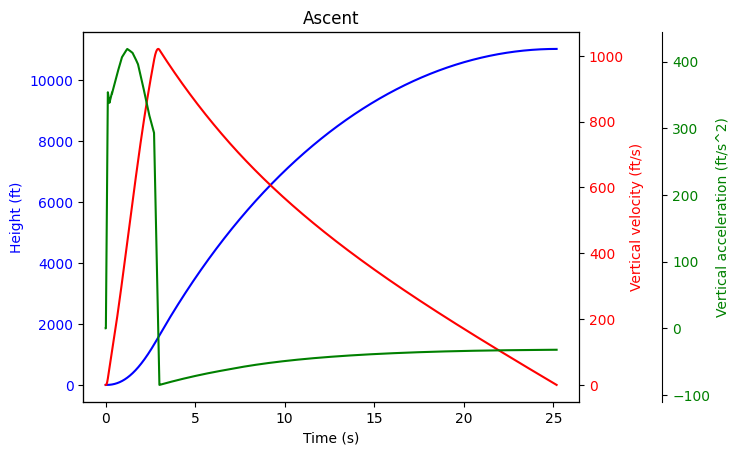

,Time (s),Height (ft),Vertical velocity (ft/s),Speed (ft/s),Vertical accel (ft/s^2),G-force (g),Re*10^7,Mach,q (kPa)
Liftoff,0.01,0.00,0.00,0.01,3.12,0.22,0.00,0.00,0.00
Off Launch Rail,0.35,14.62,99.89,101.78,353.49,11.19,0.41,0.09,0.47
Max-g Force,1.20,236.09,431.85,442.30,419.05,13.39,1.80,0.38,8.83
Max Re,2.92,1545.47,1020.90,1049.67,20.98,0.76,4.15,0.92,48.06
Max q,2.92,1552.62,1021.01,1049.80,12.22,0.50,4.15,0.92,48.06
Max Speed,2.93,1563.85,1021.06,1049.87,-1.54,0.23,4.15,0.92,48.05
Burnout,3.00,1631.18,1018.18,1047.03,-84.92,2.67,4.13,0.91,47.71
Apogee,25.18,11035.54,-0.01,145.29,-32.17,1.00,0.46,0.13,0.70


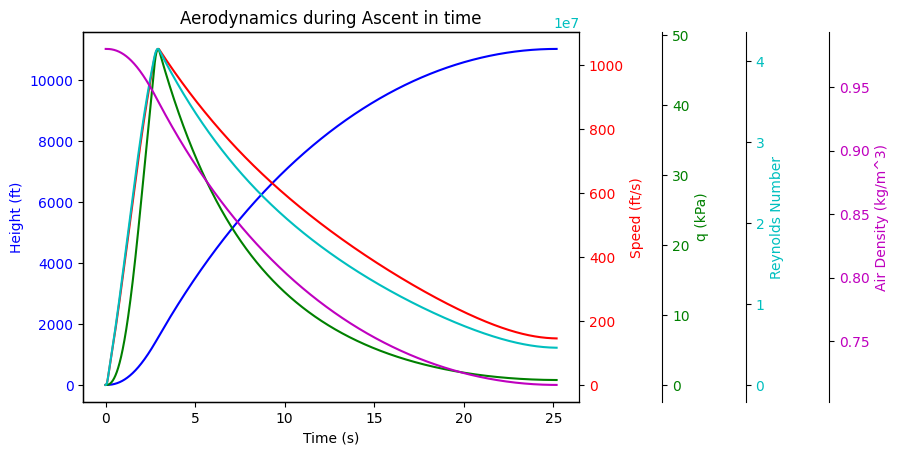

In [14]:
# Analyze Ascent
time = dataset["time"][:apogee_index]
height = dataset["height"][:apogee_index].copy()
speed = dataset["speed"][:apogee_index].copy()
v_y = dataset["v_y"][:apogee_index].copy()
a_y = dataset["a_y"][:apogee_index].copy()
a_x = dataset["a_x"][:apogee_index].copy()
g_force = np.sqrt(a_y**2 + a_x**2) / con.F_gravity

unit = "m"
if imperial:
    height *= con.m_to_ft_conversion
    speed *= con.m_to_ft_conversion
    v_y *= con.m_to_ft_conversion
    a_y *= con.m_to_ft_conversion
    a_x *= con.m_to_ft_conversion
    unit = "ft"

fig, ax1 = plt.subplots()
ax1.plot(time, height, color="b")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel(f"Height ({unit})", color="b")
ax1.tick_params(axis="y", labelcolor="b")

ax2 = ax1.twinx()
ax2.plot(time, v_y, color="r")
ax2.set_ylabel(f"Vertical velocity ({unit}/s)", color="r")
ax2.tick_params(axis="y", labelcolor="r")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))
ax3.plot(time, a_y, color="g")
ax3.set_ylabel(f"Vertical acceleration ({unit}/s^2)", color="g")
ax3.tick_params(axis="y", labelcolor="g")

plt.title("Ascent")
plt.show()

# Create table of parameters at key flight events
max_g_index = g_force.idxmax()
max_speed_index = speed.idxmax()
if dataset_choice != "simulation":
    # burnout_index is set to the later of one of two events:
    #   1) accel_plus_Fg_minus_drag is less than 5 m/s^2. Would've used zero, but the data isn't perfect so it doesn't quite get there
    #   2) time of max velocity, which helps with messier data like the TeleMega's
    dataset["drag_force"] = (dataset["q"] * dataset["reynolds_num"].apply(lambda x: Cd_rocket_at_Re(x)) * A_rocket)
    dataset["accel_plus_Fg_minus_drag"] = (dataset["a_y"] + con.F_gravity + dataset["drag_force"] / dry_mass)
    burnout_index = max(
        dataset["time"][dataset["accel_plus_Fg_minus_drag"].apply(lambda x: x < 5)].idxmin(),
        dataset["speed"].idxmax()
    )
max_q_index = dataset["q"][:apogee_index].idxmax()
max_Re_index = dataset["reynolds_num"][:apogee_index].idxmax()

parameters_at_flight_events = pd.DataFrame(
    {
        "Time (s)": [
            round(time.iloc[liftoff_index], 2),
            round(time.iloc[launch_rail_cleared_index], 2),
            round(time.iloc[max_g_index], 2),
            round(time.iloc[max_Re_index], 2),
            round(time.iloc[max_q_index], 2),
            round(time.iloc[max_speed_index], 2),
            round(time.iloc[burnout_index], 2),
            round(time.iloc[-1], 2)
        ],
        f"Height ({unit})": [
            round(height.iloc[liftoff_index], 2),
            round(height.iloc[launch_rail_cleared_index], 2),
            round(height.iloc[max_g_index], 2),
            round(height.iloc[max_Re_index], 2),
            round(height.iloc[max_q_index], 2),
            round(height.iloc[max_speed_index], 2),
            round(height.iloc[burnout_index], 2),
            round(height.iloc[-1], 2)
        ],
        f"Vertical velocity ({unit}/s)": [
            round(v_y.iloc[liftoff_index], 2),
            round(v_y.iloc[launch_rail_cleared_index], 2),
            round(v_y.iloc[max_g_index], 2),
            round(v_y.iloc[max_Re_index], 2),
            round(v_y.iloc[max_q_index], 2),
            round(v_y.iloc[max_speed_index], 2),
            round(v_y.iloc[burnout_index], 2),
            round(v_y.iloc[-1], 2)
        ],
        f"Speed ({unit}/s)": [
            round(speed.iloc[liftoff_index], 2),
            round(speed.iloc[launch_rail_cleared_index], 2),
            round(speed.iloc[max_g_index], 2),
            round(speed.iloc[max_Re_index], 2),
            round(speed.iloc[max_q_index], 2),
            round(speed.iloc[max_speed_index], 2),
            round(speed.iloc[burnout_index], 2),
            round(speed.iloc[-1], 2)
        ],
        f"Vertical accel ({unit}/s^2)": [
            round(a_y.iloc[liftoff_index], 2),
            round(a_y.iloc[launch_rail_cleared_index], 2),
            round(a_y.iloc[max_g_index], 2),
            round(a_y.iloc[max_Re_index], 2),
            round(a_y.iloc[max_q_index], 2),
            round(a_y.iloc[max_speed_index], 2),
            round(a_y.iloc[burnout_index], 2),
            round(a_y.iloc[-1], 2)
        ],
        f"G-force (g)": [
            round(g_force.iloc[liftoff_index], 2),
            round(g_force.iloc[launch_rail_cleared_index], 2),
            round(g_force.iloc[max_g_index], 2),
            round(g_force.iloc[max_Re_index], 2),
            round(g_force.iloc[max_q_index], 2),
            round(g_force.iloc[max_speed_index], 2),
            round(g_force.iloc[burnout_index], 2),
            round(g_force.iloc[-1], 2)
        ],
        f"Re*10^7": [
            round(dataset["reynolds_num"].iloc[liftoff_index] / pow(10, 7), 2),
            round(dataset["reynolds_num"].iloc[launch_rail_cleared_index] / pow(10, 7), 2),
            round(dataset["reynolds_num"].iloc[max_g_index] / pow(10, 7), 2),
            round(dataset["reynolds_num"].iloc[max_Re_index] / pow(10, 7), 2),
            round(dataset["reynolds_num"].iloc[max_q_index] / pow(10, 7), 2),
            round(dataset["reynolds_num"].iloc[max_speed_index] / pow(10, 7), 2),
            round(dataset["reynolds_num"].iloc[burnout_index] / pow(10, 7), 2),
            round(dataset["reynolds_num"].iloc[-1] / pow(10, 7), 2)
        ],
        f"Mach": [
            round(hfunc.mach_number_fn(dataset["speed"].iloc[liftoff_index], dataset["temperature"].iloc[liftoff_index]), 2),
            round(hfunc.mach_number_fn(dataset["speed"].iloc[launch_rail_cleared_index], dataset["temperature"].iloc[launch_rail_cleared_index]),2),
            round(hfunc.mach_number_fn(dataset["speed"].iloc[max_g_index], dataset["temperature"].iloc[max_g_index]), 2),
            round(hfunc.mach_number_fn(dataset["speed"].iloc[max_Re_index], dataset["temperature"].iloc[max_Re_index]), 2),
            round(hfunc.mach_number_fn(dataset["speed"].iloc[max_q_index], dataset["temperature"].iloc[max_q_index]), 2),
            round(hfunc.mach_number_fn(dataset["speed"].iloc[max_speed_index], dataset["temperature"].iloc[max_speed_index]), 2),
            round(hfunc.mach_number_fn(dataset["speed"].iloc[burnout_index], dataset["temperature"].iloc[burnout_index]), 2),
            round(hfunc.mach_number_fn(dataset["speed"].iloc[-1], dataset["temperature"].iloc[-1]), 2)
        ],
        f"q (kPa)": [
            round(dataset["q"].iloc[liftoff_index] / 1000, 2),
            round(dataset["q"].iloc[launch_rail_cleared_index] / 1000, 2),
            round(dataset["q"].iloc[max_g_index] / 1000, 2),
            round(dataset["q"].iloc[max_Re_index] / 1000, 2),
            round(dataset["q"].iloc[max_q_index] / 1000, 2),
            round(dataset["q"].iloc[max_speed_index] / 1000, 2),
            round(dataset["q"].iloc[burnout_index] / 1000, 2),
            round(dataset["q"].iloc[-1] / 1000, 2)
        ],
    },
    index=[
        "Liftoff",
        "Off Launch Rail",
        "Max-g Force",
        "Max Re",
        "Max q",
        "Max Speed",
        "Burnout",
        "Apogee"
    ]
)
display(parameters_at_flight_events.sort_values(by=["Time (s)"]))

# Plot aerodynamic parameters over the ascent
fig, ax1 = plt.subplots()
ax1.plot(time, height, color="b", label="Height")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel(f"Height ({unit})", color="b")
ax1.tick_params(axis="y", labelcolor="b")

ax2 = ax1.twinx()
ax2.plot(time, speed, color="r", label="Speed")
ax2.set_ylabel(f"Speed ({unit}/s)", color="r")
ax2.tick_params(axis="y", labelcolor="r")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))
ax3.plot(time, dataset["q"][0:apogee_index] / 1000, color="g", label="q")
ax3.set_ylabel("q (kPa)", color="g")
ax3.tick_params(axis="y", labelcolor="g")

ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 120))
ax4.plot(time, dataset["reynolds_num"][0:apogee_index], color="c", label="Reynolds Number")
ax4.set_ylabel("Reynolds Number", color="c")
ax4.tick_params(axis="y", labelcolor="c")

ax5 = ax1.twinx()
ax5.spines["right"].set_position(("outward", 180))
ax5.plot(time, dataset["air_density"][0:apogee_index], color="m", label="Air Density")
ax5.set_ylabel("Air Density (kg/m^3)", color="m")
ax5.tick_params(axis="y", labelcolor="m")

plt.title("Aerodynamics during Ascent in time")
plt.show()

## Airbrakes Simulation

In [15]:
# Simulate airbrakes flight

# Set flightpath until airbrake deployment as identical
airbrake_deployment = burnout_index + 1
pre_brake_flight = dataset.head(airbrake_deployment).copy()

# Set timestep based on dataset
if dataset_choice in ["telemetrum", "telemega"]:
    timestep = 0.01
else:
    timestep = 0.001

# Using the default airbrakes, the current airbrakes model in configs.py. Can set up others
ascent = fsim.simulate_airbrakes_flight(pre_brake_flight, rocket=rocket, timestep=timestep)[0]
# how high should the rocket overshoot without deployment, motor selction

,Time (s),Height (ft),Speed (ft/s),Accel (ft/s^2),G-force (g)
Apogee with Airbrakes,23.21,9941.94,125.73,-32.17,1.0
Apogee without Airbrakes,25.18,11035.54,145.29,-32.17,1.0
Delta,-1.97,-1093.60,-19.56,0.00,0.0
% Delta,-7.82,-9.91,-13.46,-0.00,0.0


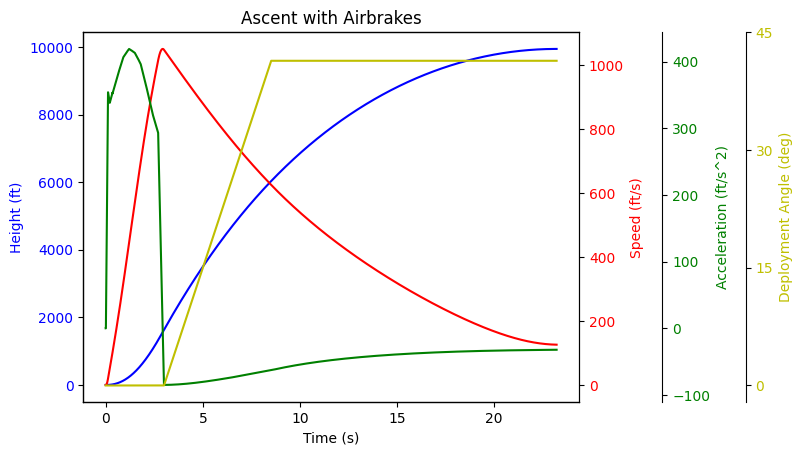

In [16]:
# Analyze ascent
height = ascent["height"].copy()
speed = ascent["speed"].copy()
accel = ascent["a_y"].copy()
apogee = ascent["height"].iloc[-1]
unit = "m"
if imperial:
    height *= con.m_to_ft_conversion
    speed *= con.m_to_ft_conversion
    accel *= con.m_to_ft_conversion
    apogee *= con.m_to_ft_conversion
    unit = "ft"

# df with deltas
parameters_at_apogee = pd.DataFrame(
    {
        "Time (s)": [
            round(ascent["time"].iloc[-1], 2),
            round(parameters_at_flight_events.iloc[-1].iloc[0], 2),
        ],
        f"Height ({unit})": [
            round(height.iloc[-1], 2),
            round(parameters_at_flight_events.iloc[-1].iloc[1], 2),
        ],
        f"Speed ({unit}/s)": [
            round(speed.iloc[-1], 2),
            round(parameters_at_flight_events.iloc[-1].iloc[3], 2),
        ],
        f"Accel ({unit}/s^2)": [
            round(accel.iloc[-1], 2),
            round(parameters_at_flight_events.iloc[-1].iloc[4], 2),
        ],
        f"G-force (g)": [
            round(abs(ascent["a_y"].iloc[-1] / con.F_gravity), 2),
            round(parameters_at_flight_events.iloc[-1].iloc[5], 2),
        ],
    },
    index=["Apogee with Airbrakes", "Apogee without Airbrakes"]
)

delta_values = (
    parameters_at_apogee.loc["Apogee with Airbrakes"]
    - parameters_at_apogee.loc["Apogee without Airbrakes"]
)
parameters_at_apogee.loc["Delta"] = delta_values
percent_delta_values = round(
    delta_values / parameters_at_apogee.loc["Apogee without Airbrakes"] * 100, 2
)
parameters_at_apogee.loc["% Delta"] = percent_delta_values
display(parameters_at_apogee)

# Plot ascent
fig, ax1 = plt.subplots()
ax1.plot(ascent["time"], height, color="b")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel(f"Height ({unit})", color="b")
ax1.tick_params(axis="y", labelcolor="b")

ax2 = ax1.twinx()
ax2.plot(ascent["time"], speed, color="r")
ax2.set_ylabel(f"Speed ({unit}/s)", color="r")
ax2.tick_params(axis="y", labelcolor="r")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))
ax3.plot(ascent["time"], accel, color="g")
ax3.set_ylabel(f"Acceleration ({unit}/s^2)", color="g")
ax3.tick_params(axis="y", labelcolor="g")

ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 120))
ax4.plot(ascent["time"], ascent["deployment_angle"], color="y")
ax4.set_ylabel(f"Deployment Angle (deg)", color="y")
ax4.tick_params(axis="y", labelcolor="y")
ax4.set_yticks(range(0, 46, 15))


plt.title("Ascent with Airbrakes")
plt.show()